![](https://i.imgur.com/EHwHRCJ.jpeg)

**Goal:** Correctly classify Taylor Swift lyric to correct album based on text data alone

In [1]:
# calculation packages
import numpy as np 
import pandas as pd 

# textual analysis packages 
from sklearn.feature_extraction.text import TfidfVectorizer

# machine learning packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# visualization
import matplotlib.pyplot as plt

In [2]:
# data
data = pd.read_csv('/Users/emma/Desktop/oldschool/ml_perspectives/project/data/thisone.csv')
data = data.drop('Unnamed: 0', axis=1)

In [4]:
# feature engineering
def looking_at_top(X, features):
    '''
    Takes in vectorized data and feature names to show the top 20 most 
    important features
    Inputs:
        X: (numpy array) an array of tf-idf vectorized features
        features: (numpy array) an array of the names of the features
    '''
    
    feature_np = np.asarray(np.sum(X, axis = 0))
    feature_np = feature_np.reshape(-1)

    top = []

    for x in np.argsort(feature_np)[::-1][:21]:
        top.append((features[x], feature_np[x]))

        df = pd.DataFrame(top)
    
    return df

# stop words
stop_words = ['a', 'an', 'and', 'are', 'as', 'at', 'be', 'but', 'by', 'for', 'if', 'in', 'into', 'is', 'it', 
              'not', 'of', 'on', 'or', 'such', 'that', 'the', 'their', 'then', 'there', 'these', 'they', 'this', 'to', 'was', 'will', 'with', 're', 
              'don', 've', 'll', 'isn', ]

# isolating lyrics
lyric_text = data['lyrics']


#NGRAM(1, 3)
vectorizer = TfidfVectorizer(strip_accents = 'ascii', stop_words = stop_words, ngram_range= (1, 3))

# fitting
X_13 = vectorizer.fit_transform(lyric_text)

# checking shape
print(X_13.shape)

# checking features
feature_names_13 = vectorizer.get_feature_names_out()

looking_at_top(X_13, feature_names_13)


(4584, 49457)


,0,1
0,you,148.890813
1,me,73.944305
2,my,63.418646
3,oh,59.750744
4,we,52.266900
5,your,52.208628
6,all,47.852716
7,like,46.305066
8,know,42.288580
9,so,37.412549


**L1/Lasso**

In [39]:
album_names = data['album_name']
# stratified data
X_train, X_test, y_train, y_test = train_test_split(X_13, album_names, test_size = 0.2, random_state = 13, stratify = album_names)

In [40]:
lr_l1 = LogisticRegression(random_state=13, solver='saga', penalty='l1', max_iter = 400, multi_class = 'multinomial', C=1.0).fit(X_train, y_train)
print('stratified score:', round(lr_l1.score(X_test, y_test),3))

stratified score: 0.342


**L2/Ridge**

In [42]:
# setting the solver to 'saga' will allow me to set 'multiclass' to multinomial, which will improve preformance
lr = LogisticRegression(random_state=13, solver='saga', multi_class = 'multinomial', penalty='l2', C=1.0).fit(X_train, y_train)
print('stratified score:', round(lr.score(X_test, y_test),3))

stratified score: 0.576


In [43]:
# pulling out coefficents
coefficients = np.round(lr.coef_, 3)
print('coefficients:', coefficients)
coefficients_df = coefficients.reshape(-1)

coefficients: [[-0.017 -0.017 -0.017 ...  0.     0.     0.   ]
 [-0.02  -0.02  -0.02  ...  0.     0.     0.   ]
 [-0.015 -0.015 -0.015 ...  0.     0.     0.   ]
 ...
 [-0.013 -0.013 -0.013 ...  0.     0.     0.   ]
 [ 0.155  0.155  0.155 ...  0.     0.     0.   ]
 [-0.014 -0.014 -0.014 ...  0.     0.     0.   ]]


In [44]:
# looking at important coefficents
df = pd.DataFrame({'feature': np.tile(feature_names_13, len(coefficients)),
                   'coef': coefficients_df})   
df = df.sort_values(['coef'], ascending=False).iloc[:20]
df

,feature,coef
266042,karma,2.410
460946,he,2.407
42706,we,2.220
123904,mr,2.063
328260,red,2.038
142937,when,1.922
45081,wish,1.917
205846,daylight,1.905
462176,his,1.857
21986,love,1.847


In [49]:
# confusion matrix for best performing model
y_pred = lr.predict(X_test) 

confusion_m = confusion_matrix(y_test, y_pred)
print('confusion_matrix:')
print(confusion_m)

confusion_matrix:
[[ 70   0   3   0   0   0  27   1   6   0]
 [  5  38   0   0   0   2  31   0   7   0]
 [  3   1  57   0   1   0  26   1  13   1]
 [  5   0   1  19   0   2  31   0   9   0]
 [  7   0   4   0  47   0  19   1   5   0]
 [  3   1   1   0   0  45  17   0  16   0]
 [  2   2   5   0   0   0 109   0  11   3]
 [  3   1   5   0   0   0  26  49   1   0]
 [  4   0   5   0   0   0  26   0  70   1]
 [  2   1   6   0   2   0  24   1   8  24]]


In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        1989       0.67      0.65      0.66       107
    evermore       0.86      0.46      0.60        83
    fearless       0.66      0.55      0.60       103
    folklore       1.00      0.28      0.44        67
       lover       0.94      0.57      0.71        83
   midnights       0.92      0.54      0.68        83
         red       0.32      0.83      0.47       132
  reputation       0.92      0.58      0.71        85
   speak now       0.48      0.66      0.56       106
taylor swift       0.83      0.35      0.49        68

    accuracy                           0.58       917
   macro avg       0.76      0.55      0.59       917
weighted avg       0.72      0.58      0.59       917



roc score: 0.88


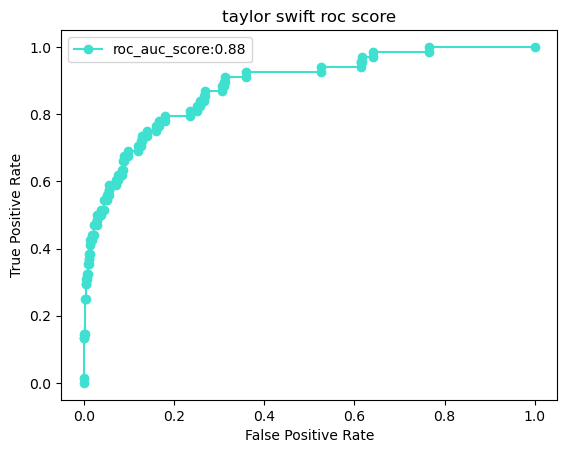

roc score: 0.88


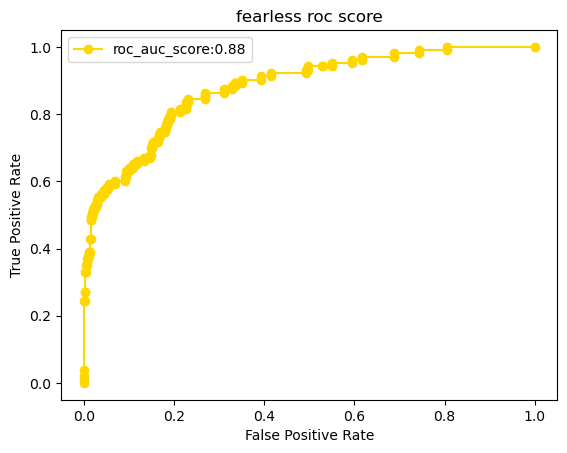

roc score: 0.86


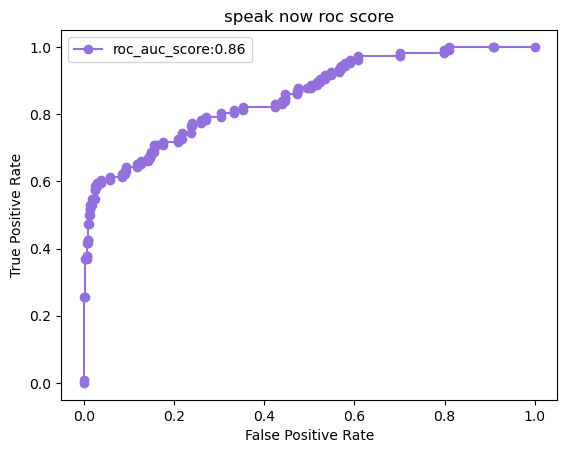

roc score: 0.87


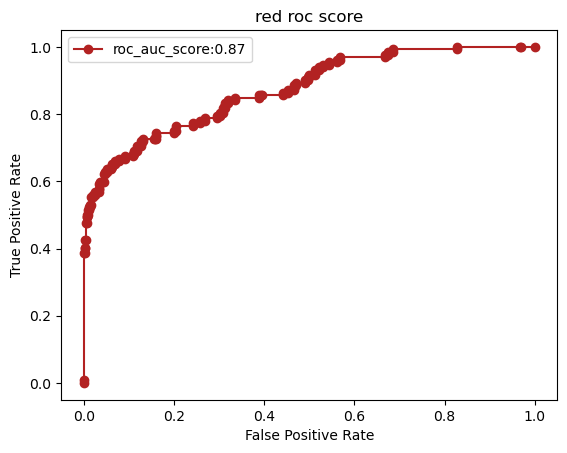

roc score: 0.89


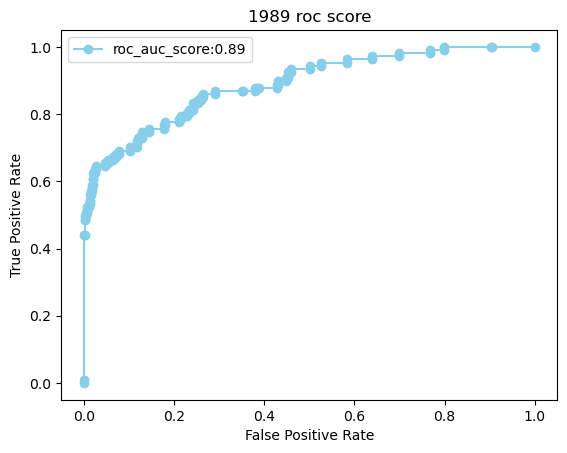

roc score: 0.93


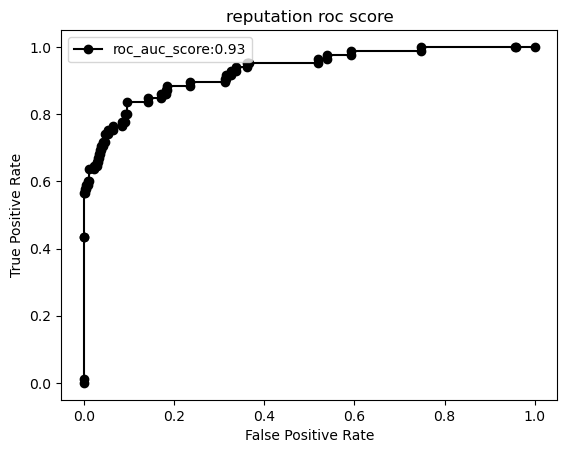

roc score: 0.88


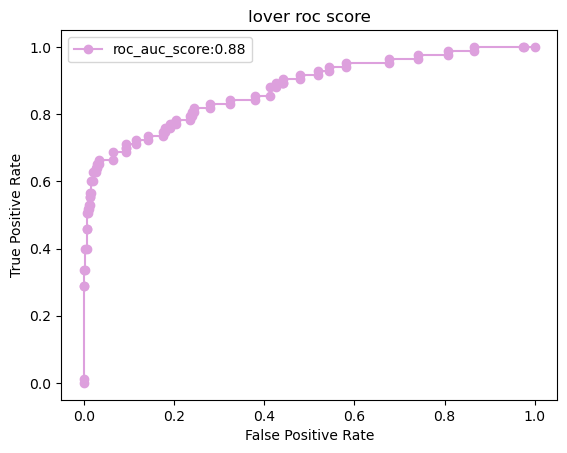

roc score: 0.91


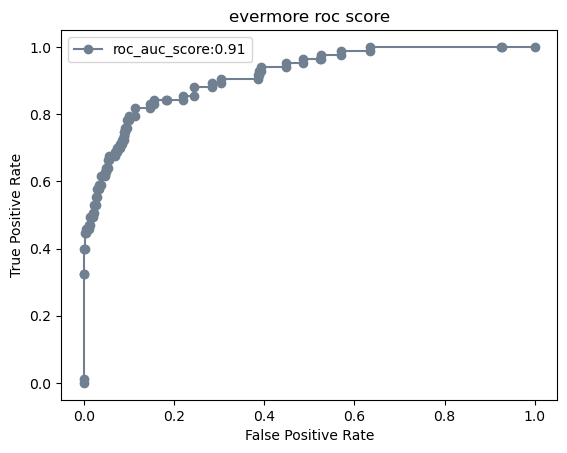

roc score: 0.88


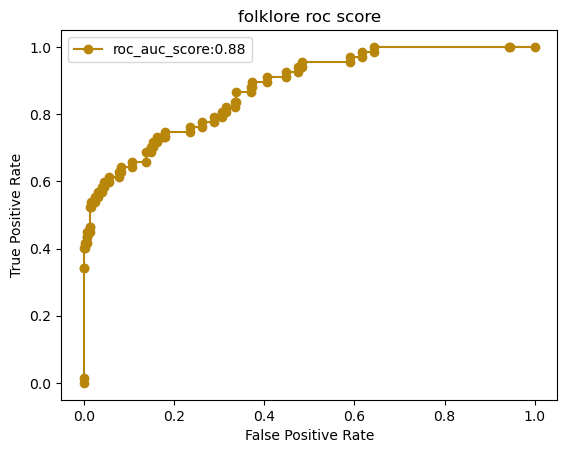

roc score: 0.91


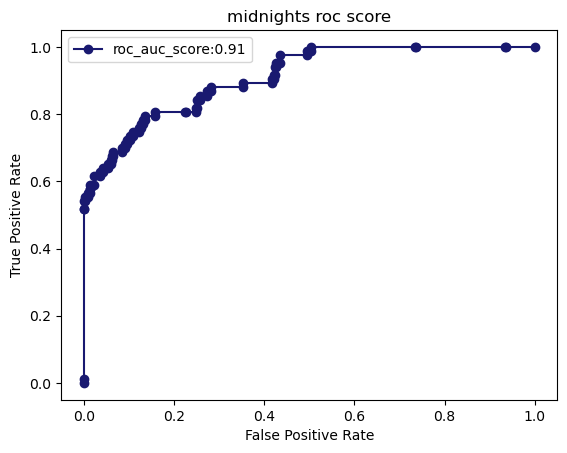

In [51]:
y_pred = lr.predict_proba(X_test)
# creating functions to see see ROC AUC curves for each album
def rc_func(album_name, y_train, y_test, y_pred):
    # trying for another album
    label_binarizer = LabelBinarizer().fit(y_train)
    label_y_test = label_binarizer.transform(y_test)

    # setting up to make ROC curve showing a certain class
    class_name = album_name
    # creating a class id
    class_id = np.flatnonzero(label_binarizer.classes_ == class_name)[0]

    # slicing to isolate the class
    y_actual = label_y_test[:, class_id]
    y_pred_class = y_pred[:, class_id]
    fpr, tpr, thresholds = roc_curve(y_actual, y_pred_class)

    # getting score
    roc_score = round(roc_auc_score(y_actual, y_pred_class), 2)
    print('roc score:', roc_score)
    return roc_score, fpr, tpr

def rc_graph(album, roc_score, color, fpr, tpr):
    plt.plot(fpr,tpr,'o-',color = color, label="roc_auc_score:"+str(roc_score))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(f'{album} roc score')
    plt.legend()
    plt.show()

colors = ['turquoise', 'gold', 'mediumpurple', 'firebrick', 'skyblue', 'black', 'plum', 'slategrey', 'darkgoldenrod', 'midnightblue']
for i, album in enumerate(data['album_name'].unique()):
    roc_score, fpr, tpr = rc_func(album, y_train, y_test, y_pred)
    rc_graph(album, roc_score, colors[i], fpr, tpr)

**Pipeline and Grid Search**

In [52]:
# creating a pipeline object that uses tf idf vectorization
pipeline = Pipeline(
    [("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(solver = 'saga', multi_class = 'multinomial',))])

# and verifying that it will do the correct steps
pipeline.steps

[('tfidf', TfidfVectorizer()),
 ('clf', LogisticRegression(multi_class='multinomial', solver='saga'))]

In [53]:
parameters = {
    "tfidf__ngram_range": ((3, 3), (1,3)),  
    "clf__C": (3.0, 4.0, 5.0),
}

In [55]:
X_train, X_test, y_train, y_test = train_test_split(data['lyrics'], data['album_name'], test_size = 0.2, random_state = 13, stratify = data['album_name'])
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

print('Starting grid search')
print('possible parameters:')
print(parameters)

grid_search.fit(X_train, y_train)

Starting grid search
possible parameters:
{'tfidf__ngram_range': ((3, 3), (1, 3)), 'clf__C': (3.0, 4.0, 5.0)}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/emma/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(multi_class='multinomial',
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf__C': (3.0, 4.0, 5.0),
                         'tfidf__ngram_range': ((3, 3), (1, 3))},
             verbose=1)

In [56]:
best_score = round(grid_search.best_score_,3)
best_parameters = grid_search.best_estimator_.get_params()

In [57]:
print("Best score:", best_score)
print("Best parameters:")

for param_name in sorted(parameters.keys()):
    print(f"\t{param_name}: {best_parameters[param_name]}")

Best score: 0.622
Best parameters:
	clf__C: 5.0
	tfidf__ngram_range: (1, 3)


In [60]:
album_names = data['album_name']
X_train, X_test, y_train, y_test = train_test_split(X_13, album_names, random_state = 13, test_size = 0.2, stratify = album_names)
lr = LogisticRegression(random_state = 13, solver = 'saga', penalty = 'l2', C=5.0, multi_class = 'multinomial').fit(X_train, y_train)
print('score:', round(lr.score(X_test, y_test), 3))

score: 0.624


In [61]:
# looking at improved conf. matrix
y_pred = lr.predict(X_test)

confusion_m = confusion_matrix(y_test, y_pred)
print(confusion_m)

[[75  2  2  1  0  3 13  2  6  3]
 [ 3 49  0  1  2  7 13  0  8  0]
 [ 3  2 61  0  3  1 19  3  8  3]
 [ 7  1  3 33  0  7 10  0  5  1]
 [12  1  3  0 54  1  8  1  3  0]
 [ 4  2  2  2  3 52  8  1  7  2]
 [ 4  2  7  2  1  0 97  1 12  6]
 [ 3  1  3  0  0  1 17 55  3  2]
 [ 6  3  8  0  0  1 15  2 68  3]
 [ 3  0  7  1  4  3 16  1  5 28]]


In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        1989       0.62      0.70      0.66       107
    evermore       0.78      0.59      0.67        83
    fearless       0.64      0.59      0.61       103
    folklore       0.82      0.49      0.62        67
       lover       0.81      0.65      0.72        83
   midnights       0.68      0.63      0.65        83
         red       0.45      0.73      0.56       132
  reputation       0.83      0.65      0.73        85
   speak now       0.54      0.64      0.59       106
taylor swift       0.58      0.41      0.48        68

    accuracy                           0.62       917
   macro avg       0.68      0.61      0.63       917
weighted avg       0.66      0.62      0.63       917



**Kfold Validation**

In [63]:
scores = []
X = X_13
y = data['album_name']

strat_kf = StratifiedKFold(n_splits=6, shuffle = True, random_state = 13)

for train, test in strat_kf.split(X, y):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]

    lrm = LogisticRegression(random_state = 13, solver='sag', penalty='l2', C= 5.0).fit(X_train, y_train)
    score = round(lrm.score(X_test, y_test),3)
    scores.append(score)

print('scores:', scores)
mean_score = np.mean(scores)
print('average score:', np.round(mean_score, 3))

scores: [0.641, 0.635, 0.631, 0.653, 0.662, 0.619]
average score: 0.64


**Extra Error Analysis.. Trying to figure out where the model is going wrong**

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X_13, album_names, random_state = 13, test_size = 0.2, stratify = album_names)

# getting predicted guesses
predicted_album = lr.predict(X_test)

# and actual guesses
actual_album = y_test

In [107]:
# creating a function to get index point and the data points it guessed/actual
mismatched_data = []

for i, (predicted, actual) in enumerate(zip(predicted_album, actual_album)):
    if predicted != actual:
        mismatched_data.append((i, predicted, actual))

print(mismatched_data)

[(2, 'reputation', 'taylor swift'), (5, 'fearless', 'red'), (6, 'red', 'evermore'), (7, 'red', '1989'), (10, '1989', 'speak now'), (11, 'red', 'taylor swift'), (13, 'taylor swift', 'midnights'), (19, 'midnights', 'evermore'), (24, 'red', 'taylor swift'), (27, 'red', 'speak now'), (28, '1989', 'red'), (31, 'speak now', 'fearless'), (36, '1989', 'evermore'), (39, 'red', 'fearless'), (40, 'red', 'folklore'), (44, 'red', 'fearless'), (48, 'evermore', 'fearless'), (51, 'red', 'fearless'), (52, 'speak now', 'fearless'), (54, 'red', 'taylor swift'), (57, 'red', 'fearless'), (58, '1989', 'folklore'), (65, 'speak now', 'red'), (70, 'red', 'taylor swift'), (72, 'fearless', 'reputation'), (74, 'lover', 'midnights'), (75, 'evermore', 'reputation'), (77, 'fearless', 'red'), (79, 'speak now', 'midnights'), (80, 'speak now', 'evermore'), (84, 'taylor swift', 'red'), (85, 'speak now', 'folklore'), (87, 'red', 'reputation'), (89, 'red', '1989'), (92, 'red', 'reputation'), (93, 'lover', 'red'), (94, '19

In [108]:
# train test splitting again, but instead of TTS on the vectorized lyrics, I want the text lyrics
# being careful to use the exact same TTS
X_train, X_test_text, y_train, y_test_text = train_test_split(data['lyrics'], album_names, random_state = 13, test_size = 0.2, stratify = album_names)

In [109]:
X_test_text.reset_index(drop = True, inplace = True)

In [110]:
X_test_text

0      I'd never forget you as long as I live, and I ...
1      Find myself at your door Just like all those t...
2       Asking God if he could play it again Da-da-da-da
3      I miss you like it was the very first night ta...
4                                           Bye bye baby
                             ...                        
912    I threw it in the bushes and knocked on your d...
913    If you would've been the one I, I, I persist a...
914    Yeah, oh, oh, oh 'Cause the players gonna play...
915    Maybe it would've been fine And that made me w...
916    Now we've got problems And I don't think we ca...
Name: lyrics, Length: 917, dtype: object

In [111]:
# now that I have that, I can iterate through mismatched data and see what the lyric is by matching it with 
# X_test_text
full_mismatched_data = []

for mismatched in mismatched_data:
    
    index, pred, actual = mismatched
    lyric = X_test_text[index]
    full_mismatched_data.append((pred, actual, lyric))

full_mismatched_data

[('reputation',
  'taylor swift',
  'Asking God if he could play it again Da-da-da-da'),
 ('fearless',
  'red',
  'Well, I tried to fit in with your upper-crust circles Yeah, they let me sit in back when we were in love'),
 ('red',
  'evermore',
  'I swear (Is there a line that we can just go cross?) You were there'),
 ('red',
  '1989',
  'Time moved too fast, you play it back Buttons on a coat, lighthearted joke'),
 ('1989',
  'speak now',
  "You learn my secrets and you figure out why I'm guarded You say we'll never make my parents' mistakes"),
 ('red',
  'taylor swift',
  "I don't think that passenger seat Has ever looked this good to me"),
 ('taylor swift',
  'midnights',
  "Of everyone you burned just to get there It's coming back around"),
 ('midnights',
  'evermore',
  'How it was supposed to be Did you hear about the girl who lives in delusion?'),
 ('red',
  'taylor swift',
  "It's strange to think the songs we used to sing The smiles, the flowers, everything is gone"),
 ('red'

In [116]:
pd.set_option('display.max_colwidth', None)

# and for readibility, I will turn it into a dataframe
columns = ['predicted album', 'actual', 'lyric']

df = pd.DataFrame(full_mismatched_data, columns = columns)

df

,predicted album,actual,lyric
0,reputation,taylor swift,Asking God if he could play it again Da-da-da-da
1,fearless,red,"Well, I tried to fit in with your upper-crust circles Yeah, they let me sit in back when we were in love"
2,red,evermore,I swear (Is there a line that we can just go cross?) You were there
3,red,1989,"Time moved too fast, you play it back Buttons on a coat, lighthearted joke"
4,1989,speak now,You learn my secrets and you figure out why I'm guarded You say we'll never make my parents' mistakes
...,...,...,...
340,red,lover,Luck of the draw only draws the unlucky And so I became the butt of the joke
341,reputation,midnights,"I made you my world (Huh), have you heard? (Huh) I can reclaim the land"
342,fearless,taylor swift,There's a fire inside of you That can't help but shine through
343,speak now,evermore,I threw it in the bushes and knocked on your door And we live in peace


- So now I can see what albums it's mixing up with one another. Let's see if there is any explanation.

In [118]:
coefficients = lr.coef_
coefficients_df = pd.DataFrame(coefficients, columns=feature_names_13, index=lr.classes_)
coefficients_df

,05,05 see,05 see two,1500s,1500s off,1500s off foreign,16,16 lost,16 lost film,16th,...,yourself tonight get,yourself what,yourself what you,yourself you,yourself you can,yourself your,yourself your war,youth,youth roll,youth roll your
1989,-0.044732,-0.044732,-0.044732,-0.036517,-0.036517,-0.036517,-0.053258,-0.053258,-0.053258,-0.104177,...,-0.042592,0.0,0.0,0.0,0.0,-0.040938,-0.040938,0.0,0.0,0.0
evermore,-0.061765,-0.061765,-0.061765,-0.037811,-0.037811,-0.037811,-0.054740,-0.054740,-0.054740,-0.093571,...,-0.028988,0.0,0.0,0.0,0.0,-0.082056,-0.082056,0.0,0.0,0.0
fearless,-0.031490,-0.031490,-0.031490,-0.093052,-0.093052,-0.093052,-0.072450,-0.072450,-0.072450,-0.111430,...,-0.038649,0.0,0.0,0.0,0.0,-0.063654,-0.063654,0.0,0.0,0.0
folklore,-0.038034,-0.038034,-0.038034,-0.035881,-0.035881,-0.035881,-0.059924,-0.059924,-0.059924,-0.062240,...,0.360977,0.0,0.0,0.0,0.0,-0.055144,-0.055144,0.0,0.0,0.0
lover,-0.053314,-0.053314,-0.053314,-0.030293,-0.030293,-0.030293,0.501750,0.501750,0.501750,0.785094,...,-0.034580,0.0,0.0,0.0,0.0,-0.023866,-0.023866,0.0,0.0,0.0
midnights,-0.040713,-0.040713,-0.040713,-0.045329,-0.045329,-0.045329,-0.043618,-0.043618,-0.043618,-0.079116,...,-0.033833,0.0,0.0,0.0,0.0,-0.091099,-0.091099,0.0,0.0,0.0
red,-0.067526,-0.067526,-0.067526,-0.048756,-0.048756,-0.048756,-0.076001,-0.076001,-0.076001,-0.078893,...,-0.055536,0.0,0.0,0.0,0.0,-0.076811,-0.076811,0.0,0.0,0.0
reputation,-0.030006,-0.030006,-0.030006,-0.052172,-0.052172,-0.052172,-0.040929,-0.040929,-0.040929,-0.079816,...,-0.032890,0.0,0.0,0.0,0.0,-0.035503,-0.035503,0.0,0.0,0.0
speak now,0.407779,0.407779,0.407779,0.411782,0.411782,0.411782,-0.062015,-0.062015,-0.062015,-0.103204,...,-0.046757,0.0,0.0,0.0,0.0,0.515279,0.515279,0.0,0.0,0.0
taylor swift,-0.040199,-0.040199,-0.040199,-0.031972,-0.031972,-0.031972,-0.038816,-0.038816,-0.038816,-0.072645,...,-0.047154,0.0,0.0,0.0,0.0,-0.046209,-0.046209,0.0,0.0,0.0


In [164]:
# from there, we can see the most important coefficents to each album and 
# we can see that in some of the mismatched examples, the top coefficents from the 'guessed' album exists

for album in coefficients_df.index:
    print(f"Top features for {album}:")
    top_features = coefficients_df.loc[album].nlargest(20) 
    print(top_features)
    print( )
    print( )


Top features for 1989:
we                3.491212
wish              3.274002
love              3.138835
wonderland        2.895369
eh                2.546563
wish you          2.427546
know places       2.322460
mmm               2.235281
why you have      2.224640
shake             2.214017
now we            2.188512
oh                2.133077
oh no             2.108880
new               2.091519
why you           2.081182
like like         2.072487
places            2.008620
wish you would    1.946718
how works         1.941548
came              1.915583
Name: 1989, dtype: float64


Top features for evermore:
evermore              3.186139
happiness             2.995317
he did                2.636164
closure               2.274191
all about you         2.235228
know better           2.174002
all about             2.156722
goddamn               2.097777
champagne problems    2.065983
you left              1.995462
sit                   1.918988
dorothea              1.906794
problems 

In [121]:
# wanting to see if any combos pop up frequently, I was expecting albums like 'evermore' and 'folklore' to get confused for one another
p_actual_pairs = []

for index, row in df.iterrows():
    predicted = row['predicted album']
    actual = row['actual']
    p_actual_pairs.append((predicted, actual))

In [123]:
p_actual_pairs

[('reputation', 'taylor swift'),
 ('fearless', 'red'),
 ('red', 'evermore'),
 ('red', '1989'),
 ('1989', 'speak now'),
 ('red', 'taylor swift'),
 ('taylor swift', 'midnights'),
 ('midnights', 'evermore'),
 ('red', 'taylor swift'),
 ('red', 'speak now'),
 ('1989', 'red'),
 ('speak now', 'fearless'),
 ('1989', 'evermore'),
 ('red', 'fearless'),
 ('red', 'folklore'),
 ('red', 'fearless'),
 ('evermore', 'fearless'),
 ('red', 'fearless'),
 ('speak now', 'fearless'),
 ('red', 'taylor swift'),
 ('red', 'fearless'),
 ('1989', 'folklore'),
 ('speak now', 'red'),
 ('red', 'taylor swift'),
 ('fearless', 'reputation'),
 ('lover', 'midnights'),
 ('evermore', 'reputation'),
 ('fearless', 'red'),
 ('speak now', 'midnights'),
 ('speak now', 'evermore'),
 ('taylor swift', 'red'),
 ('speak now', 'folklore'),
 ('red', 'reputation'),
 ('red', '1989'),
 ('red', 'reputation'),
 ('lover', 'red'),
 ('1989', 'fearless'),
 ('red', 'midnights'),
 ('midnights', 'folklore'),
 ('1989', 'taylor swift'),
 ('red', 'fe

In [128]:
# and now I will go through and count the amount of each combo
value_counts = {}

for pair in p_actual_pairs:
    value_counts[pair] = value_counts.get(pair, 0) + 1

# and then sort those combos from greatest to least
sorted_value_counts = sorted(value_counts.items(), key=lambda x: x[1], reverse=True)

sorted_value_counts

[(('red', 'fearless'), 19),
 (('red', 'reputation'), 17),
 (('red', 'taylor swift'), 16),
 (('red', 'speak now'), 15),
 (('red', 'evermore'), 13),
 (('red', '1989'), 13),
 (('speak now', 'red'), 12),
 (('1989', 'lover'), 12),
 (('red', 'folklore'), 10),
 (('speak now', 'fearless'), 8),
 (('speak now', 'evermore'), 8),
 (('red', 'midnights'), 8),
 (('red', 'lover'), 8),
 (('fearless', 'speak now'), 8),
 (('fearless', 'red'), 7),
 (('midnights', 'evermore'), 7),
 (('1989', 'folklore'), 7),
 (('speak now', 'midnights'), 7),
 (('midnights', 'folklore'), 7),
 (('fearless', 'taylor swift'), 7),
 (('1989', 'speak now'), 6),
 (('taylor swift', 'red'), 6),
 (('speak now', '1989'), 6),
 (('speak now', 'folklore'), 5),
 (('speak now', 'taylor swift'), 5),
 (('1989', 'red'), 4),
 (('1989', 'midnights'), 4),
 (('lover', 'taylor swift'), 4),
 (('1989', 'evermore'), 3),
 (('fearless', 'reputation'), 3),
 (('lover', 'midnights'), 3),
 (('1989', 'fearless'), 3),
 (('1989', 'taylor swift'), 3),
 (('tayl

In [130]:
# creating df
most_freq = pd.DataFrame(sorted_value_counts, columns =['pair', 'count'], index=None)

# splitting the pair col
most_freq[['predicted', 'actual']] = most_freq['pair'].apply(pd.Series)

# dropping pair
most_freq.drop('pair', axis=1, inplace=True)

# reordering cols
most_freq = most_freq[['predicted', 'actual', 'count']]

most_freq

,predicted,actual,count
0,red,fearless,19
1,red,reputation,17
2,red,taylor swift,16
3,red,speak now,15
4,red,evermore,13
...,...,...,...
70,midnights,fearless,1
71,taylor swift,folklore,1
72,midnights,speak now,1
73,folklore,evermore,1


In [139]:
# looks like there is no super majority of combos, but red is popping up a lot under predicted... want to look closer
most_guessed = {}

for pred, _ in p_actual_pairs:
    most_guessed[pred] = most_guessed.get(pred, 0) + 1

most_guessed

{'reputation': 11,
 'fearless': 35,
 'red': 119,
 '1989': 45,
 'taylor swift': 20,
 'midnights': 24,
 'speak now': 57,
 'evermore': 14,
 'lover': 13,
 'folklore': 7}

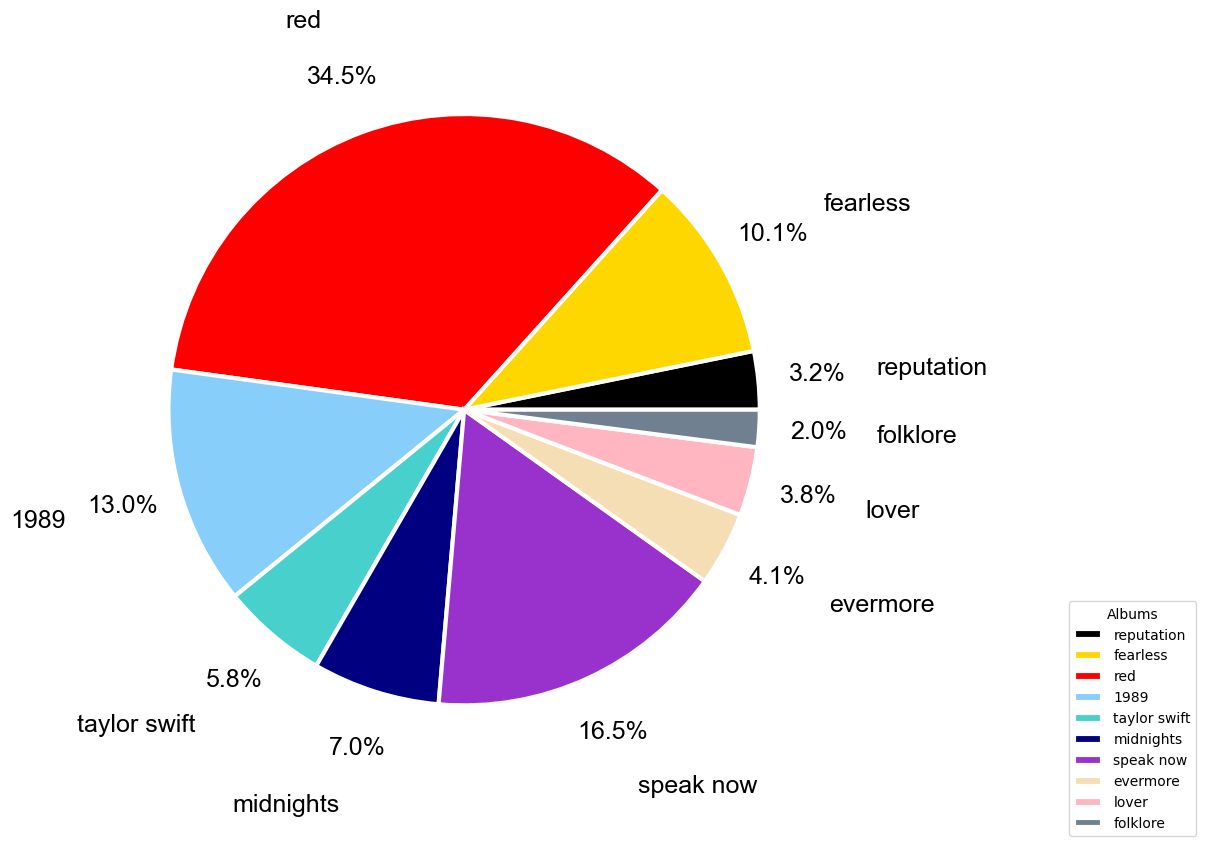

In [162]:
labels = list(most_guessed.keys())
sizes = list(most_guessed.values())
colors = ['k', 'gold', 'r', 'lightskyblue', 'mediumturquoise', 'navy', 'darkorchid', 'wheat', 'lightpink', 'slategrey']

plt.pie(sizes, labels=labels, radius = 2, textprops={"family": "Arial", "size": 18}, labeldistance =1.4, pctdistance = 1.2, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, autopct='%1.1f%%', colors = colors)

plt.legend(loc="best", bbox_to_anchor=(2.5,0), title="Albums")

plt.show()

In [ ]:
# consistent with what we saw in the CF, where red has lowest precision, followed by speak now